In [1]:
import math
import base64
import io
import json
import random
from itertools import product, combinations
from pathlib import Path
from collections import Counter
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import torch
from tensorboard.backend.event_processing import event_accumulator
from plotnine import *
import magicsoup as ms
from e1_co2_fixing.chemistry import CHEMISTRY

theme_set(theme_minimal())
THIS_DIR = Path(".") / "e1_co2_fixing"
RUNS_DIR = THIS_DIR / "runs"

In [2]:
def load_hparams(runs_glob: str) -> pd.DataFrame:
    records = []
    for hparams_file in RUNS_DIR.glob(f"{runs_glob}/hparams.json"):
        run_dir = hparams_file.parent
        with open(hparams_file) as fh:
            hparams = json.load(fh)
        name = run_dir.name
        run = "_".join(name.split("_")[:-1])
        trial = name.split("_")[-1]
        records.append({**hparams, "run": run, "trial": trial, "name": name})

    return pd.DataFrame.from_records(records)

def load_scalars(runs_glob: str, scalars: list[tuple[str, str]]) -> pd.DataFrame:
    records = []
    for event_file in RUNS_DIR.glob(f"{runs_glob}/*.out.tfevents.*"):
        for tag, scalar in scalars:
            name = event_file.parent.name
            tf_ea = event_accumulator.EventAccumulator(str(event_file))
            tf_ea.Reload()
            for obj in tf_ea.Scalars(tag):
                records.append(
                    {
                        "name": name,
                        "scalar": scalar,
                        "value": obj.value,
                        "step": obj.step,
                    }
                )
    return pd.DataFrame.from_records(records)

def find_diffs(df: pd.DataFrame, name="name", step="step", val="value") -> pd.DataFrame:
    records = []
    for _, df in df.groupby(name):
        s = df[val].diff(periods=1)
        records.extend(df.loc[s > 0.0, [step, val, name]].to_dict("records"))
    return pd.DataFrame.from_records(records)

def find_steps(run_dir: Path) -> list[int]:
    steps = [int(d.name.split("step=")[-1]) for d in run_dir.glob("step=*")]
    return sorted(steps)

def get_proteome_doms(cell: ms.Cell) -> list[list[str]]:
    proteome_strs = []
    for protein in cell.proteome:
        domstrs = []
        for dom in protein.domains:
            if isinstance(dom, ms.TransporterDomain):
                domstrs.append(f"{dom.molecule} [trnsp]")
            if isinstance(dom, ms.CatalyticDomain):
                subs = " + ".join(sorted(d.name for d in dom.substrates))
                prods = " + ".join(sorted(d.name for d in dom.products))
                domstrs.append(" <-> ".join(sorted([subs, prods])))
            if isinstance(dom, ms.RegulatoryDomain):
                domstrs.append(f"{dom.effector} [reg]")
        proteome_strs.append(domstrs)
    return proteome_strs


#### 2023-05-06 train WL pathway in phases

I trained cells to adopt the WL pathway by sucessively moving away from a complex medium to minimal medium in phases.
In each phase some genes would be added to the surviving cells and a molecule species would be removed from the medium.
Each phase begins with an adaption period with a high mutation rate that linearly decreases to a natural low mutation rate
followed by a static period with no change.

I created a small world map to run small quick simulations to see which hyperparameters should perform the best.
_I.e._ I wanted to find out what the fastest procedure for training the WL pathway would be.
There is a score from 0 to 1 for how far a run would come to learning the whole pathway.
2 major parameters are for how many generations cells have to grow to complete the current phase:
`n_adapt_gens` for generations in adaption phase and `n_static_gens` for generations in a following static phase.
I noticed shorter phases (smaller number of generations) performed overall better, which was counter intuitive.

In [3]:
run_glob = "2023-05-06_*"
scalars = [
    ("Other/Phase", "phase"),
    ("Other/Score", "score"),
]

scalars_df = load_scalars(run_glob, scalars)
phases_df = find_diffs(scalars_df.loc[scalars_df["scalar"] == "phase"])
splits_df = find_diffs(scalars_df.loc[scalars_df["scalar"] == "split"])
hparams_df = load_hparams(run_glob)
hparams_df[["run", "trial", "n_adapt_gens", "n_static_gens", "init_cell_cover",	"mol_divide_k",	"mol_kill_k", "genome_kill_k", "lgt_rate", "split_ratio"]]

,run,trial,n_adapt_gens,n_static_gens,init_cell_cover,mol_divide_k,mol_kill_k,genome_kill_k,lgt_rate,split_ratio
0,2023-05-06_17-01,1,30.0,30.0,0.2,30.0,0.04,2000.0,0.001,0.2
1,2023-05-06_15-42,2,50.0,50.0,0.2,30.0,0.04,2000.0,0.001,0.2
2,2023-05-06_15-42,0,50.0,50.0,0.2,30.0,0.04,2000.0,0.001,0.2
3,2023-05-06_16-33,2,20.0,20.0,0.2,30.0,0.04,2000.0,0.001,0.2
4,2023-05-06_16-33,1,20.0,20.0,0.2,30.0,0.04,2000.0,0.001,0.2
5,2023-05-06_15-06,1,10.0,10.0,0.2,30.0,0.04,2000.0,0.001,0.2
6,2023-05-06_16-33,0,20.0,20.0,0.2,30.0,0.04,2000.0,0.001,0.2
7,2023-05-06_15-42,1,50.0,50.0,0.2,30.0,0.04,2000.0,0.001,0.2
8,2023-05-06_15-06,2,10.0,10.0,0.2,30.0,0.04,2000.0,0.001,0.2
9,2023-05-06_15-06,0,10.0,10.0,0.2,30.0,0.04,2000.0,0.001,0.2


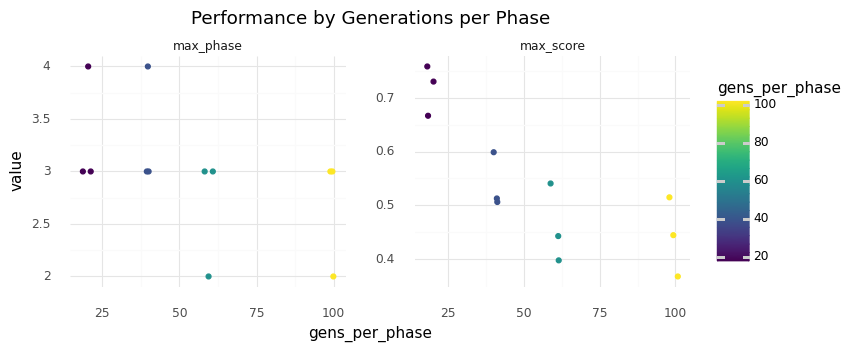

<ggplot: (8750228878769)>

In [12]:
df = hparams_df[["run", "trial", "name", "n_adapt_gens", "n_static_gens"]].copy()
df["gens_per_phase"] = df["n_adapt_gens"] + df["n_static_gens"]
max_scores = scalars_df[scalars_df["scalar"] == "score"].groupby("name")["value"].max()
max_phase = scalars_df[scalars_df["scalar"] == "phase"].groupby("name")["value"].max()

df = df \
    .merge(max_scores.reset_index().rename(columns={"value": "max_score"}), on="name") \
    .merge(max_phase.reset_index().rename(columns={"value": "max_phase"}), on="name") \
    .melt(id_vars=["run", "trial", "name", "gens_per_phase"], value_vars=["max_phase", "max_score"])

(ggplot(df)
    + geom_jitter(aes(y="value", x="gens_per_phase", color="gens_per_phase"), height=0, width=2)
    + facet_wrap("~ variable", scales="free")
    + theme(figure_size=(8, 3), subplots_adjust={'wspace': 0.25})
    + ggtitle("Performance by Generations per Phase"))

In [42]:
run_glob = "2023-05-06_15-*"
scalars = [
    ("Cells/total", "cells"),
    ("Cells/Generation", "generation"),
    ("Other/Phase", "phase"),
    ("Molecules/X[int]", "X[i]"),
    ("Molecules/acetyl-CoA[int]", "acetyl-CoA[i]"),
    ("Molecules/methyl-FH4[int]", "methyl-FH4[i]"),
    ("Molecules/formyl-FH4[int]", "formyl-FH4[i]"),
]

scalars_df = load_scalars(run_glob, scalars)
phases_df = find_diffs(scalars_df.loc[scalars_df["scalar"] == "phase"])
splits_df = find_diffs(scalars_df.loc[scalars_df["scalar"] == "split"])
hparams_df = load_hparams(run_glob)

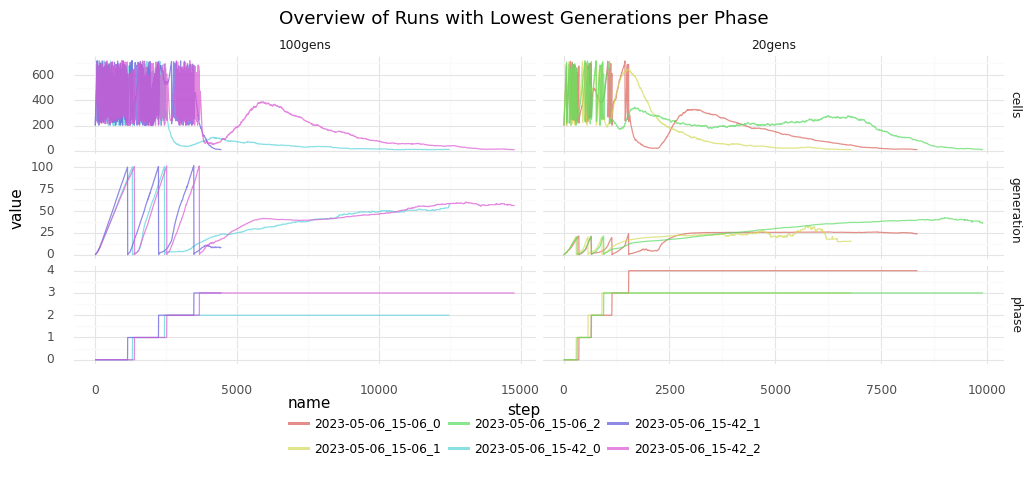

<ggplot: (8750228473298)>

In [47]:
scalars = ["cells", "generation", "phase"]
df = scalars_df[scalars_df["scalar"].isin(scalars)].copy()
df["scalar"] = pd.Categorical(df["scalar"], categories=scalars, ordered=True)
df = df.merge(hparams_df[["run", "trial", "name", "n_adapt_gens", "n_static_gens"]], on="name")
df["gens_per_phase"] = (df["n_adapt_gens"] + df["n_static_gens"]).astype(int).astype(str) + "gens"

(ggplot(df)
    + geom_line(aes(y="value", x="step", group="name", color="name"), alpha=0.7)
    + facet_grid("scalar ~ gens_per_phase", scales="free")
    + theme(figure_size=(12, 4), legend_position="bottom")
    + ggtitle("Overview of Runs with Lowest Generations per Phase"))

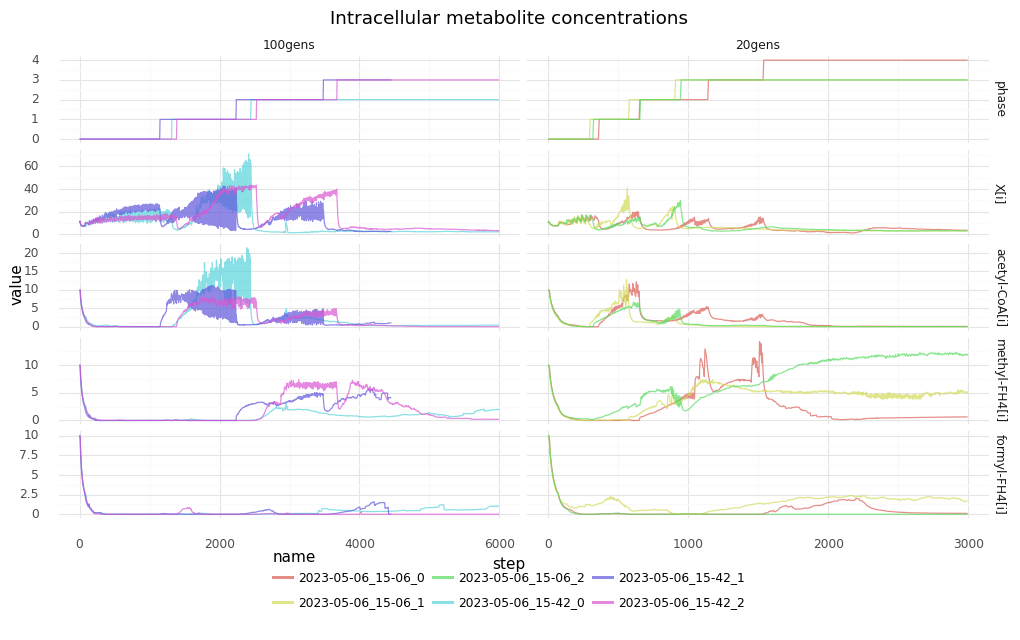

<ggplot: (8750228072467)>

In [49]:
scalars = ["phase", "X[i]", "acetyl-CoA[i]", "methyl-FH4[i]", "formyl-FH4[i]"]
df = scalars_df[scalars_df["scalar"].isin(scalars)].copy()
df["scalar"] = pd.Categorical(df["scalar"], categories=scalars, ordered=True)
df = df.merge(hparams_df[["run", "trial", "name", "n_adapt_gens", "n_static_gens"]], on="name")
df["gens_per_phase"] = (df["n_adapt_gens"] + df["n_static_gens"]).astype(int).astype(str) + "gens"

df = df[
    ((df["step"] < 6000) & (df["gens_per_phase"] == "100gens"))
    | ((df["step"] < 3000) & (df["gens_per_phase"] == "20gens"))
]

(ggplot(df)
    + geom_line(aes(y="value", x="step", group="name", color="name"), alpha=0.7)
    + facet_grid("scalar ~ gens_per_phase", scales="free")
    + theme(figure_size=(12, 6), legend_position="bottom")
    + ggtitle("Intracellular metabolite concentrations"))

In [3]:
world = ms.World.from_file(rundir=RUNS_DIR, device="cpu")
mol_2_idx = {d.name: i for i, d in enumerate(world.chemistry.molecules)}

In [10]:
run_name = "2023-05-07_13-16_2"
#from_step = phases_df.loc[phases_df["value"] == 4, "step"].iloc[0]
steps = find_steps(RUNS_DIR / run_name)
step = [d for d in steps if d >= 50][0]
world.load_state(statedir=RUNS_DIR / run_name / f"step={step}")
print(f"{world.n_cells:,} cells at step {step:,}")

292 cells at step 50


In [11]:
n_cells = world.n_cells
proteomes = [get_proteome_doms(world.get_cell(by_idx=d)) for d in range(n_cells)]

In [13]:
cell_doms = []
for prots in proteomes:
    cell_doms.append(set(d for p in prots for d in p))

counted_doms = Counter(d for doms in cell_doms for d in doms)
sorted_doms = sorted((d, k) for k, d in counted_doms.items())

records = []
rng_idxs = list(range(n_cells))
for _, dom in reversed(sorted_doms):
    n = sum(1 for i in rng_idxs if dom in cell_doms[i])
    records.append({"dom": dom, "n": n})
df = pd.DataFrame.from_records(records)
df["freq"] = df["n"] / n_cells
df["type"] = "catal"
df.loc[df["dom"].str.endswith("[trnsp]"), "type"] = "trnsp"
df.loc[df["dom"].str.endswith("[reg]"), "type"] = "reg"

df[df["freq"] > 0.5].sort_values(by="type")["dom"]

0    X [trnsp]
1    E [trnsp]
Name: dom, dtype: object

## Wrong Genes Defined

#### 2023-05-05 train WL pathway in phases

I trained the cells to adopt the WL pathway by sucessively moving away from a complex medium to minimal medium in phases.
In each phase some genes would be added to the surviving cells and a molecule species would be removed from the media.
Each phase begins with an adaption period with a high mutation rate that linearly decreases to a natural low mutation rate
followed by a static period with no change.

In `WL_2023-05-05_18-15_0` adapt and static periods were 100 generations each.
The initial concentration of essential molecules in complex medium was 20.
I tried many times with 10 before, but I noticed that on the onset of each phase cells need some time to adapt.
It helps them if they still have some remaining molecules that they can live on for a few steps.
I think linearly decreasing the to-be-removed molecule species would also work.

I also split the WL pathway training into 7 phases.
Before, I always tried with 5 phases, but when introducing

$$
\text{methyl-FH4} + \text{CO} + \text{HS-CoA} \rightleftharpoons \text{acetyl-CoA} + \text{FH4} \quad \text{and} \quad
\text{CO2} + \text{NADPH} \rightleftharpoons \text{CO} + \text{NADP}
$$

and removing acetyl-CoA at phase 3 cells would just die.
I figured that's too much, since they also need to learn to restore NADPH at that time.
7 phases is the most careful I can do.
And indeed this time they failed much later during phase 5.
It almost died in 4, but then recovered.
I think an unfortunate split removed some a lot of high performing cells.
The failure at 5 was so abrupt, I was suspecting some systemic problem.


In [3]:
run_glob = "WL_2023-05-05_18-15_*"
scalars = [
    ("Cells/total", "cells"),
    ("Cells/Generation", "generation"),
    ("Cells/Survival", "survival"),
    ("Other/Split", "split"),
    ("Other/Phase", "phase"),
    ("Other/MutationRate", "mutations"),
    ("Other/Score", "score"),
]

scalars_df = load_scalars(run_glob, scalars)
phases_df = find_diffs(scalars_df.loc[scalars_df["scalar"] == "phase"])
splits_df = find_diffs(scalars_df.loc[scalars_df["scalar"] == "split"])
hparams_df = load_hparams(run_glob)
hparams_df

,n_adapt_gens,n_static_gens,mut_scheme,init_cell_cover,split_ratio,split_thresh_cells,split_thresh_mols,run,trial,name
0,100.0,100.0,linear,0.2,0.2,0.7,0.2,WL_2023-05-05_18-15,0,WL_2023-05-05_18-15_0


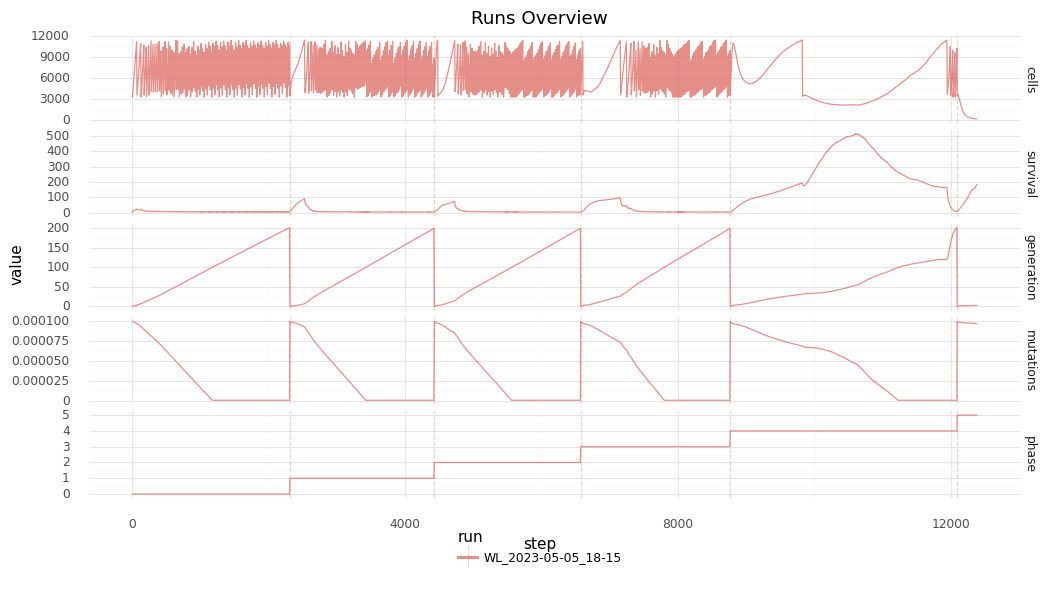

<ggplot: (8749336572250)>

In [9]:
scalars = ["cells", "survival", "generation", "mutations", "phase"]
df = scalars_df[scalars_df["scalar"].isin(scalars)].copy()
df["scalar"] = pd.Categorical(df["scalar"], categories=scalars, ordered=True)
df = df.merge(hparams_df[["run", "trial", "name"]], on="name")
df1 = phases_df.merge(hparams_df[["run", "trial", "name"]], on="name")

(ggplot(df)
    + geom_vline(aes(xintercept="step", color="run"), alpha=0.3, linetype="dashed", data=df1)
    + geom_line(aes(y="value", x="step", group="name", color="run"), alpha=0.7)
    + facet_grid("scalar ~ .", scales="free")
    + theme(figure_size=(12, 6), legend_position="bottom")
    + ggtitle("Runs Overview"))

Cells struggled a lot with phase 4. In phase 4 methyl-FH4 was removed from the medium and they were getting transporters for formyl-FH4 together with
enzymes for

$$
\text{formyl-FH4} + \text{NADPH} \rightleftharpoons \text{methylen-FH4} + \text{NADP}
\quad , \quad
\text{methylen-FH4} + \text{NADPH}\rightleftharpoons \text{methyl-FH4} + \text{NADPH}
$$

I was kind of expecting that they struggle there.
Now there are 2 more reactions that require NADPH.
So far the NADPH path (NADP importer and enzyme using up E) only needed to supply 1 reaction with NADPH.
Nevertheless, they got over it.

They failed more or less immediately at phase 5.
Here, formyl-FH4 is removed from the medium, transporters for FH4 and formate are added, and enzymes for

$$
\text{formate} + \text{FH4} + \text{ATP} \rightleftharpoons \text{formyl-FH4} + \text{ADP}
\quad , \quad
2 \text{ADP} + \text{E} \rightleftharpoons 2 \text{ATP}
$$

Shouldn't be that hard. 2 new reactions but they don't interrupt another ongoing path.
Below I am taking a look at the cells right after the beginning of phase 5.

In [4]:
world = ms.World.from_file(rundir=RUNS_DIR, device="cpu")
mol_2_idx = {d.name: i for i, d in enumerate(world.chemistry.molecules)}

In [5]:
run_name = "WL_2023-05-05_18-15_0"
from_step = phases_df.loc[phases_df["value"] == 5, "step"].iloc[0]
steps = find_steps(RUNS_DIR / run_name)
step = [d for d in steps if d > from_step][0]
world.load_state(statedir=RUNS_DIR / run_name / f"step={step}")
print(f"{world.n_cells:,} cells at step {step:,}")

3,644 at step 12,100


In [20]:
n_cells = world.n_cells
proteomes = [get_proteome_doms(world.get_cell(by_idx=d)) for d in range(n_cells)]

In [34]:
cell_doms = []
for prots in proteomes:
    cell_doms.append(set(d for p in prots for d in p))

counted_doms = Counter(d for doms in cell_doms for d in doms)
sorted_doms = sorted((d, k) for k, d in counted_doms.items())

records = []
rng_idxs = list(range(n_cells))
for _, dom in reversed(sorted_doms):
    n = sum(1 for i in rng_idxs if dom in cell_doms[i])
    records.append({"dom": dom, "n": n})
df = pd.DataFrame.from_records(records)
df["freq"] = df["n"] / n_cells
df["type"] = "catal"
df.loc[df["dom"].str.endswith("[trnsp]"), "type"] = "trnsp"
df.loc[df["dom"].str.endswith("[reg]"), "type"] = "reg"

df[df["freq"] > 0.7].sort_values(by="type")["dom"]

10                   CO2 + NADPH <-> NADP + formate
17                        CO + NADP <-> CO2 + NADPH
16                     FH4 + formate <-> formyl-FH4
9         HS-CoA + X + X + X + X + X <-> acetyl-CoA
7        NADP + methylen-FH4 <-> NADPH + formyl-FH4
20                                      ADP <-> ATP
4     CO + HS-CoA + methyl-FH4 <-> FH4 + acetyl-CoA
3        NADP + methyl-FH4 <-> NADPH + methylen-FH4
1                                E + NADP <-> NADPH
13                                        FH4 [reg]
6                                    HS-CoA [trnsp]
8                                acetyl-CoA [trnsp]
19                                      FH4 [trnsp]
11                                     3PGA [trnsp]
12                                      CO2 [trnsp]
14                              malonyl-CoA [trnsp]
15                             succinyl-CoA [trnsp]
2                                         E [trnsp]
18                                  formate [trnsp]
5           

These are the domains that are each together present in over 70% of cells (each cell has at least all these domains).
At first, these domains make all sense.
Some transporters that were necessary in earlier phases but are no necessary anymore were already removed (X, CO, methyl-FH4).
All previously learned catalytic regions are still there.

After looking at it for a while I noticed that there is no ADP importer.
So, cells could only generate ATP from there existent ADP stores.
I didn't define it in the phases definition.
And the way the simulationw as setup, it also didn't include ADP as essential molecule.

In [35]:
i_adp = mol_2_idx["ADP"]
world.cell_molecules[:, i_adp].mean()

tensor(0.0097)

Interestingly over 70% of cells aquired transporters for malonyl-CoA and succinyl-CoA.
The following catalytic domains are less frequent than 70% of cells.
Most of them are present in less than 10% of cells.
However, these cells also contain the domains from above.
So, they have a function carbonyl branch of the WL pathway.
It looks to me like some cells were developing parts of the 3-Hydroxypropionate Bicycle.

In [50]:
df[(df["freq"] <= 0.7) & (df["type"] == "catal")].sort_values(by="freq", ascending=False).iloc[:10]["dom"]

21                                       NADP <-> NADPH
27                     CO2 + acetyl-CoA <-> malonyl-CoA
31                NADP + succinate <-> NADPH + fumarate
32                                  fumarate <-> malate
33             acetyl-CoA + pyruvate <-> citramalyl-CoA
34                  HS-CoA + succinate <-> succinyl-CoA
36        HS-CoA + citrate <-> acetyl-CoA + oxalacetate
38       glyoxylate + propionyl-CoA <-> methylmalyl-CoA
41                   methylmalonyl-CoA <-> succinyl-CoA
42    NADP + NADP + NADP + propionyl-CoA <-> NADPH +...
Name: dom, dtype: object